In [1]:
## SETUP
import pandas as pd

df = pd.read_csv('datasets/Movie.csv')

rs = 10 # random state

df.info()

import warnings
warnings.filterwarnings("ignore")

#print(df.get_value(index=0, col='Description')[:200])

# average length of Description column
print(df['Description'].apply(lambda x: len(x)).mean() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 21 columns):
Cast 1          799 non-null object
Cast 2          799 non-null object
Cast 3          799 non-null object
Cast 4          799 non-null object
Cast 5          799 non-null object
Cast 6          799 non-null object
Description     799 non-null object
Director 1      799 non-null object
Director 2      799 non-null object
Director 3      799 non-null object
Genre           799 non-null object
Rating          799 non-null object
Release Date    799 non-null object
Runtime         799 non-null object
Studio          799 non-null object
Title           799 non-null object
Writer 1        799 non-null object
Writer 2        799 non-null object
Writer 3        799 non-null object
Writer 4        799 non-null object
Year            799 non-null int64
dtypes: int64(1), object(20)
memory usage: 131.2+ KB
761.7859824780976


In [2]:
## DATA PREPROCESSING
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

# init lemmatizer and punctuation filter
lemm = WordNetLemmatizer()
punct = set(string.punctuation)

# load provided stopwords
df_stop = pd.read_csv('datasets/Movie.csv')

# join provided stopwords with the default NLTK english stopwords
stopwords = set(df_stop['Description']).union( set(sw.words('english')))

def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ,
    }.get(tag[0], wn.NOUN)
    
    return lemm.lemmatize(token, tag)


In [3]:
# takes a document string, split into tokens and preprocess them
def cab_tokenizer(document):
    tokens = []
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and the create
        # part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')
            
            # if stopword, ignore and continue
            if token in stopwords:
                continue
            # if punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue
            #Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens

In [4]:
# vectorise/ transform tokens into matrices
from sklearn.feature_extraction.text import TfidfVectorizer

# tf idf vectorizer
tfidf_vec = TfidfVectorizer( tokenizer=cab_tokenizer, ngram_range=(1,2))
X = tfidf_vec.fit_transform(df['Description'])

# see the number of unique tokens produced by the vectorizer. Lots of them...
print( len(tfidf_vec.get_feature_names() ))

65478


In [5]:
## INITIAL DOCUMENT ANALYSIS
from sklearn.cluster import KMeans

# K means clustering using the term vector
kmeans = KMeans(n_clusters=7, random_state=rs).fit(X)

## TODO find optimal cluster

In [14]:
# function to visualise text cluster.
def visualise_text_clusters(n_clusters, cluster_centers, terms, num_word = 5):
    # --- Params ---
    # cluster_centers: cluster centers of fitted/trained Kmeans/other centroid-based cluster
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. change as you please
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]    
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :5]:
            print(terms[term_idx], end=', ')
        print()
        
# call it
visualise_text_clusters(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

Top terms for cluster 0: c official, c, official, official site, site, 
Top terms for cluster 1: film, best, family, one, love, 
Top terms for cluster 2: christmas, school, kid, year, town, 
Top terms for cluster 3: film, new, life, boy, time, 
Top terms for cluster 4: planet, alien, time, human, earth, 
Top terms for cluster 5: life, steve, new, star, find, 
Top terms for cluster 6: love, young, century, daughter, queen, 


In [16]:
## FEATURE SELECTION AND TRANSFORMATION

import seaborn as sns
import matplotlib.pyplot as plt

# creating tf-idf terms - a bit slow, do it occasionally
def calculate_tf_idf_terms(document_col):
    #param - document_col: collection of raw document text that you want to analyze
    from sklearn.feature_extraction.text import CountVectorizer
    
    # use count vecotrizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2) )
    X_count = count_vec.fit_transform( df['Description'] )
    
    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
             'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero() }
            for t in count_vec.vocabulary_]
    return terms

terms = calculate_tf_idf_terms( df['Description'] )

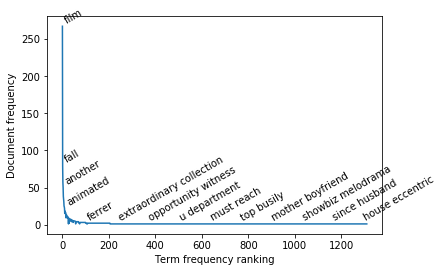

In [17]:
# visualisation of ZIPF law
def visualise_zipf(terms, itr_step = 50):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    
    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
            
    plt.show()
    
visualise_zipf(terms)

In [60]:
## filter out high and low terms

#limit the terms produced to terms that occured in min of 2 documents and max of 80% of all docs
filter_vec = TfidfVectorizer( tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=2, max_df=0.3)
X_filter = filter_vec.fit_transform( df.Description )

# see the num of unique tokens produced by the vectorizer. Reduced
print( len(filter_vec.get_feature_names() ) )

9923


In [61]:
# build another cluster based on refined features

#K means clustering using the new term vector
kmeans_fil = KMeans( n_clusters=5, random_state=rs).fit(X_filter)

In [62]:
# visualisation
visualise_text_clusters(kmeans_fil.n_clusters, kmeans_fil.cluster_centers_, filter_vec.get_feature_names() )

Top terms for cluster 0: life, family, love, find, new, 
Top terms for cluster 1: official, c official, c, official site, site, 
Top terms for cluster 2: prince, king, little, queen, come, 
Top terms for cluster 3: set, world, planet, classic, earth, 
Top terms for cluster 4: world, evil, must, save, earth, 


### Task 3: Text Mining
A leading movie review and aggregation website is planning to start an online
personalised movie recommendation service. They have a collection of individual
movie descriptions. Perform text mining on this MOVIE dataset to determine clusters
of movies based on similar topics that can be obtained from the movie descriptions.
Answer the followings in relation to this data and analysis.
1. What variables did you include in the analysis and what were their roles and
measurement level set? Justify your choice.

The only variable from the dataset used was the Description feature as this contained the most useful text pertaining to the content of the film and also contained a sufficient amount of text to be a suitable candidate for text mining.

2. Based on the ZIPF plot, list the top 10 terms that will be least useful for
clustering purpose.
    * film
    * fall
    * another
    * house eccentric
    * since husband
    * showbiz melodrama
    * mother boyfriend
    * top busily
    * must reach
    * u department
3. Did you disregard any frequent terms?
    * official
    * c official
    * site
    * official site
4. Justify the term weighting option selected.
***TODO***
5. What is the number of input features available to execute clustering?
(FYI: Note how the original text data is converted into a feature set that can
be mined for knowledge discovery.) ***TODO***
6. State how many clusters are generated? Name each cluster meaningfully
according to the terms that appear in the clusters which could be based on
the movie genre?

### 4 clusters
    * Coming of Age : life, year, find, one, young, 
    * Romance: film, story, star, love, musical, 
    * Documentary: documentary, film, life, world, c, 
    * Science Fiction: alien, earth, new, life, space, 

7. Identify the first six high frequent terms (that are not stop words) in the start
list? ***TODO***
8. Describe how these clusters can be useful in the planned online
personalised movie recommendation service.

These clusters could be used to catergorise similar films. If films descriptions fall into the same cluster, viewers who have watched one film may enjoy another one that was grouped into the same cluster.
